---

**This work was performed under the auspices of the U.S. Department of Energy by Lawrence Livermore National Laboratory under Contract DE-AC52-07NA27344.**

---

Welcome to the **2025 Lawrence Livermore National Laboratory Data Science Challenge!**

Launch Presentation consists of:
- (1) High-Level overview **(Short Slidedeck)** of current state-of-the-art methods for a variety of tasks
- (2) High-Level overview **(Dataset Card)** of MOVi-MC-AC
- (3) High-Level overview of **(OneDrive Folder)** of DSC Target Dataset: <u>**Robotics Laboratory Pick and Place Dataset**</u>


- (4) Low-Level example **(Jupyter Notebook)** of using state-of-the-art methods (SAM2) on DSC Target Dataset


- (5) Low-Level overview **(Jupyter Notebook)** of MOVi-MC-AC + DSC Tasks

**This notebook serves as the technical introduction to LLNL's MOVi-MC-AC Dataset (last bullet above), covering**:
- (1) Introduction to Image Processing / Computer Vision
- (2) Example Baseline Experiment
- (3) DSC Challenge & Tasking
  - **Task 1.1**: (Image-based) Modal Mask -> Amodal Mask
  - **Task 1.2**: (Image-based) Modal Content (RGB) -> Amodal Content (RGB)
  - **Task 2.1**: (Video-based) Modal Mask -> Amodal Mask
  - **Task 2.2**: (Video-based) Modal Content (RGB) -> Amodal Content (RGB)
  - **Transfer Test**: Apply Models on DSC Target Dataset:
    - Gather Modal Masks from some SotA method (SAM2)
    - Predict Amodal Masks, using Modal Masks
  - **Bonus Task 3**: Create Modal Masks with SAM2
  - **Bonus Task 4**: Re-ID of Objects

# Introduction to Image Processing / Computer Vision

### Imports & Util Functions

In [1]:
# pip install torch torchvision matplotlib av

> Uncomment the above cell to install necessary libraries!

In [2]:
# PyTorch, Torchvision
import torch
from torch import nn
from torchvision.transforms import ToPILImage, ToTensor
from torchvision.utils import make_grid
from torchvision.io import write_video

# Common
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import json
from IPython.display import Video

# Utils from Torchvision
tensor_to_image = ToPILImage()
image_to_tensor = ToTensor()

In [3]:
def get_img_dict(img_dir):
    img_files = [x for x in img_dir.iterdir() if x.name.endswith('.png') or x.name.endswith('.tiff')]
    img_files.sort()

    img_dict = {}
    for img_file in img_files:
        img_type = img_file.name.split('_')[0]
        if img_type not in img_dict:
            img_dict[img_type] = []
        img_dict[img_type].append(img_file)
    return img_dict

In [4]:
def get_sample_dict(sample_dir):

    camera_dirs = [x for x in sample_dir.iterdir() if 'camera' in x.name]
    camera_dirs.sort()
    
    sample_dict = {}

    for cam_dir in camera_dirs:
        cam_dict = {}
        cam_dict['scene'] = get_img_dict(cam_dir)

        obj_dirs = [x for x in cam_dir.iterdir() if 'obj_' in x.name]
        obj_dirs.sort()
        
        for obj_dir in obj_dirs:
            cam_dict[obj_dir.name] = get_img_dict(obj_dir)

        sample_dict[cam_dir.name] = cam_dict

    return sample_dict

In [5]:
def make_obj_viz(cam_dict, cam_num=0):

    n_frames = 24
    n_cols = 6

    all_obj_ids = [x for x in sample_dict['camera_0000'].keys() if 'obj_' in x]
    obj_id_str = random.sample(all_obj_ids, k=1)[0]
    obj_id_int = int(obj_id_str.split('_')[1])

    grid_tensors = []
    for i in range(n_frames):
        grid = []
        scene_rgb_tensor = image_to_tensor(Image.open(cam_dict['scene']['rgba'][i]).convert('RGB'))
        grid.append(scene_rgb_tensor)
        scene_masks_tensor = image_to_tensor(Image.open(cam_dict['scene']['segmentation'][i]).convert('RGB'))
        grid.append(scene_masks_tensor)

        scene_masks_p = Image.open(cam_dict['scene']['segmentation'][i])
        scene_masks_p_tensor = torch.tensor(np.array(scene_masks_p))
        obj_modal_tensor = (scene_masks_p_tensor==obj_id_int)
        blended_obj_modal_tensor = scene_masks_tensor*obj_modal_tensor
        grid.append(blended_obj_modal_tensor)

        obj_amodal_tensor = image_to_tensor(Image.open(cam_dict[obj_id_str]['segmentation'][i]).convert('RGB'))
        blended_obj_amodal_tensor = blended_obj_modal_tensor + (obj_amodal_tensor != obj_modal_tensor)
        grid.append(blended_obj_amodal_tensor)

        obj_rgb_tensor = image_to_tensor(Image.open(cam_dict[obj_id_str]['rgba'][i]).convert('RGB'))
        grid.append(obj_rgb_tensor)

        blended_scene_obj_tensor = (scene_rgb_tensor/3 + 2*blended_obj_amodal_tensor/3)
        grid.append(blended_scene_obj_tensor)
            
        grid_tensors.append(make_grid(grid, nrow=n_cols, padding=2, pad_value=127))
            
    return grid_tensors

In [6]:
def make_vid(grid_tensors, save_path):
    vid_tensor = torch.stack(grid_tensors, dim=1).permute(1, 2, 3, 0)
    vid_tensor = (vid_tensor*255).long()
    write_video(save_path, vid_tensor, fps=5, options={'crf':'20'})

### Exploratory Data Analysis

> Move `ff5da6d6ecae486bb294aeaf5ee8f8a1/` into current working directory

Explore the directory using side-bar navigation!
- `.png`'s should be directly openable (double-click)
- `.tiff` needs to be visualized using matplotlib, or other similar libraries
- `.json` metadata is also included

A sample directory contains 6 camera views worth of data. In each camera view, there is scene-level data, and object-centric data:

<u>Scene Level Data</u>
- RGBA images (.png) of the scene -> `rgba_00000.png`
- Depth maps (.tiff) of the scene -> `depth_00000.tiff`
- Segmentation masks (.png) of *all objects* in the scene -> `segmentation_00000.png`
  - These are **Modal Masks** -> only the "Visible" portions of objects!


<u>Object Centric Data</u>

**(for each object (e.g. `obj_0000/`)**
- RGBA images (.png) of the scene -> `rgba_00000.png`
  - **Amodal content** - "X-ray" vision of an object's apperance, through occlusion!
- Depth maps (.tiff) of the scene -> `depth_00000.tiff`
  - **Amodal depth** - "X-ray" vision of an object's depth, through occlusion!
- Segmentation masks (.png) of *all objects* in the scene -> `segmentation_00000.png`
  - **Amodal Masks** - "X-ray" vision of an object's mask, through occlusion!

#### Prepare Directory

> Uncomment the below cells to untar the sample directory!

In [7]:
# !ls

In [8]:
# !tar -xvf ff5da6d6ecae486bb294aeaf5ee8f8a1.tar.gz

#### Sample Directory

In [9]:
sample_dir = 'ff5da6d6ecae486bb294aeaf5ee8f8a1/'
sample_dir

'ff5da6d6ecae486bb294aeaf5ee8f8a1/'

In [10]:
sample_dir = Path(sample_dir)
sample_dir

PosixPath('ff5da6d6ecae486bb294aeaf5ee8f8a1')

In [11]:
cameras = list(sample_dir.iterdir())
cameras.sort()

cameras

[PosixPath('ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0000'),
 PosixPath('ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0001'),
 PosixPath('ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0002'),
 PosixPath('ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0003'),
 PosixPath('ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0004'),
 PosixPath('ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0005')]

In [12]:
sample_dict = get_sample_dict(sample_dir)
sample_dict['camera_0000'].keys()

dict_keys(['scene', 'obj_0001', 'obj_0002', 'obj_0003', 'obj_0004', 'obj_0005', 'obj_0006', 'obj_0007', 'obj_0008', 'obj_0009', 'obj_0010', 'obj_0011', 'obj_0012', 'obj_0013', 'obj_0014', 'obj_0015', 'obj_0016', 'obj_0017', 'obj_0018', 'obj_0019'])

In [13]:
sample_dict['camera_0000']['scene'].keys(), sample_dict['camera_0000']['obj_0001'].keys()

(dict_keys(['depth', 'rgba', 'segmentation']),
 dict_keys(['depth', 'rgba', 'segmentation']))

In [14]:
sample_dict['camera_0000']['obj_0001']['rgba'][:5]

[PosixPath('ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0000/obj_0001/rgba_00000.png'),
 PosixPath('ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0000/obj_0001/rgba_00001.png'),
 PosixPath('ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0000/obj_0001/rgba_00002.png'),
 PosixPath('ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0000/obj_0001/rgba_00003.png'),
 PosixPath('ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0000/obj_0001/rgba_00004.png')]

#### Scene-Level: RGB Images

Use Python Image Library (PIL) to load and view images!

In [15]:
sample_dict['camera_0000']['scene']['rgba'][0]

PosixPath('ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0000/rgba_00000.png')

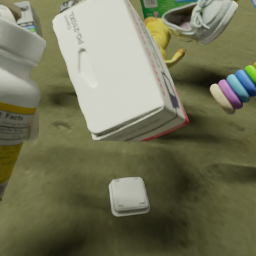

In [16]:
# Convert from 4-channels (RGBA) to 3-channels (RGB) when loading!
scene_img = Image.open(sample_dict['camera_0000']['scene']['rgba'][0]).convert('RGB')
scene_img

In [17]:
scene_img.mode

'RGB'

How are images actually represented?

In [18]:
type(scene_img)

PIL.Image.Image

PIL is only used for visualization purposes only! We can convert this into an array.

NumPy Array representation:
- 256 x 256 x 3 -> H, W, C
- Values are within [0, 255]

In [19]:
scene_img_array = np.array(scene_img)
scene_img_array.shape

(256, 256, 3)

In [20]:
scene_img_array[:2, :2]

array([[[135, 130,  99],
        [133, 128,  97]],

       [[133, 131,  97],
        [133, 129,  94]]], dtype=uint8)

Tensor representation:
- 3 x 256 x 256 -> C, H, W
- Values are within [0, 1]

In [21]:
scene_img_tensor = image_to_tensor(scene_img)
scene_img_tensor.shape

torch.Size([3, 256, 256])

In [22]:
scene_img_tensor[:, :2, :2].shape

torch.Size([3, 2, 2])

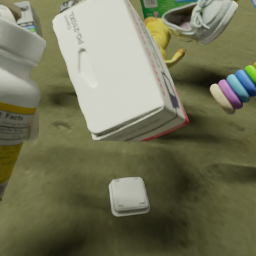

In [23]:
Image.fromarray(scene_img_array)

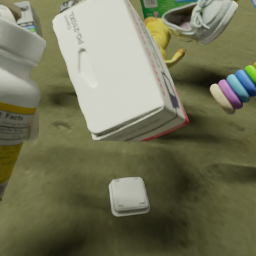

In [24]:
tensor_to_image(scene_img_tensor)

In neural networks, typically we want channels to be first, and the values to be normalized, e.g.
- C, H, W format
- between [0, 1]

Image tensors can be trimmed using slice operations!

In [25]:
scene_img_tensor.shape, scene_img_tensor[:, :125, :125].shape

(torch.Size([3, 256, 256]), torch.Size([3, 125, 125]))

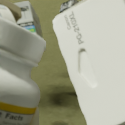

In [26]:
tensor_to_image(scene_img_tensor[:, :125, :125])

#### Scene-Level: Segmentation Masks

Python Image Library (PIL) can be used to visualize segmentation masks as well!

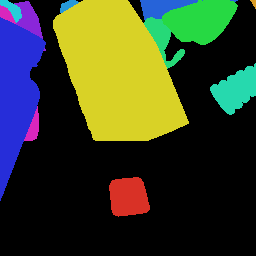

In [27]:
# Convert from 4-channels (RGBA) to 3-channels (RGB) when loading!
obj_masks = Image.open(sample_dict['camera_0000']['scene']['segmentation'][0])
obj_masks

In [28]:
obj_masks.mode

'P'

Note that the "type" of this image is `P`, instead of `RGB`
- P -> Panoptic, where each integer represents a different mask (color)

Converting this into an array/tensor will let us dig into this representation deeper

Note that these masks are **Modal** segmentation masks
- Only the *visible* portions of objects 

In [29]:
np.array(obj_masks)

array([[11, 11, 11, ...,  3,  3,  3],
       [11, 11, 11, ...,  3,  3,  3],
       [11, 11, 11, ...,  3,  3,  3],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], shape=(256, 256), dtype=uint8)

In [30]:
image_to_tensor(obj_masks)

tensor([[[0.0431, 0.0431, 0.0431,  ..., 0.0118, 0.0118, 0.0118],
         [0.0431, 0.0431, 0.0431,  ..., 0.0118, 0.0118, 0.0118],
         [0.0431, 0.0431, 0.0431,  ..., 0.0118, 0.0118, 0.0118],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]])

Note that converting directly into tensors will assume RGB image types, and skip the "integer -> unique mask" representation offered by PIL's Panoptic mode.

- Use numpy first for safely dealing with non-RGB representations instead of automatically converting into tensors.

In [31]:
obj_masks_np = np.array(obj_masks)
obj_masks_np.shape

(256, 256)

In [32]:
obj_masks_tensor = torch.tensor(obj_masks_np)
obj_masks_tensor

tensor([[11, 11, 11,  ...,  3,  3,  3],
        [11, 11, 11,  ...,  3,  3,  3],
        [11, 11, 11,  ...,  3,  3,  3],
        ...,
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0]], dtype=torch.uint8)

We can visualize objects based off their "object id" (unique integer).

In [33]:
(obj_masks_tensor == 1).long()

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

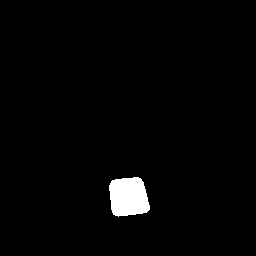

In [34]:
# object 1
tensor_to_image((obj_masks_tensor == 1).float())

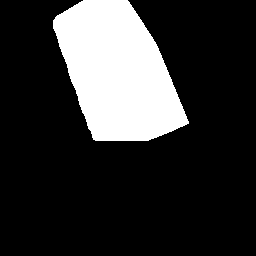

In [35]:
# object 4
tensor_to_image((obj_masks_tensor == 4).float())

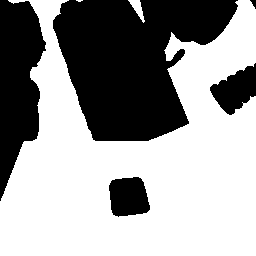

In [36]:
# object 0 -> background (no object)
tensor_to_image((obj_masks_tensor == 0).float())

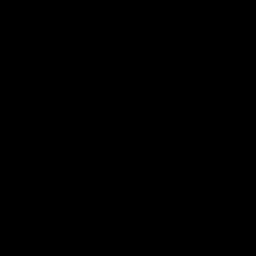

In [37]:
# object 2 -> off-screen?
tensor_to_image((obj_masks_tensor == 2).float())

#### Scene-Level: Depth Maps

`.tiff` files don't open natively with Python Image Library (PIL)

In [38]:
depth_img = Image.open(sample_dict['camera_0000']['scene']['depth'][0])
depth_img

<PIL.TiffImagePlugin.TiffImageFile image mode=F size=256x256>

In [39]:
depth_arr = np.array(depth_img)
depth_arr.shape

(256, 256)

In [40]:
depth_arr.min(), depth_arr.max()

(np.float32(3.5496569), np.float32(24.274927))

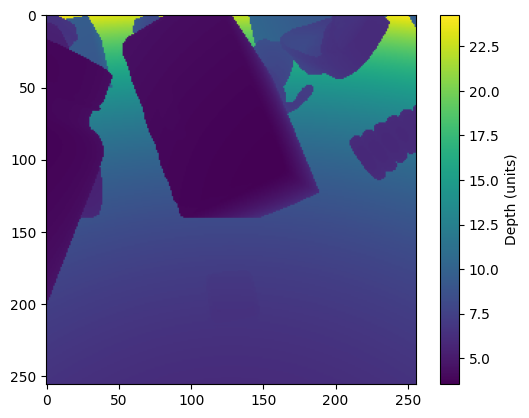

In [41]:
plt.imshow(depth_arr)
plt.colorbar(label='Depth (units)')

In [42]:
depth_tensor = torch.tensor(depth_arr)
depth_tensor.shape, depth_tensor.min(), depth_tensor.max()

(torch.Size([256, 256]), tensor(3.5497), tensor(24.2749))

How to normalize depth, no guaranteed min/max like with RGB images (0, 255)!

#### Object-Centric Data

Each object within the scene has it's own directory of data!

Just as we saw with the scene-level data modalities, we have:
- RGB Images
- Segmentation Masks
- Depth Maps

**Scene-level** data shows objects when they are visible.

**Object-centric** data is "cohesive". It obeys [object permanence](https://en.wikipedia.org/wiki/Object_permanence)!
- Learn to understand both the visible + occluded portions of the objects (like X-Ray vision!)

> Object permanence: Objects continue to exist even when they are not visible.

For each of the data modalities shown at the scene-level, we'll have **Amodal** versions of it that correspond to **Object-Centric** needs.

Namely, Modal vs. Amodal (i.e. Visible vs. Occluded/Invisible):
- Object RGB Content
- Object Segmentation Mask
- Object Depth

Below are some differences between scene-level data and object-centric data!
- Using `obj_0009` as a great example, as it's partially occluded on the first frame

First let's look at the Amodal Mask of `obj_0009`, note the difference between the visible portions and occluded portions!

Amodal masks are represented on a per-object basis, so they can simply be represented as a binary image, rather than a panoptic image (where unique integers corresponded to different object modal masks, all in the same "image")

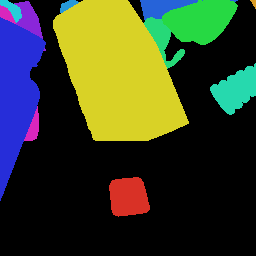

In [43]:
obj_masks

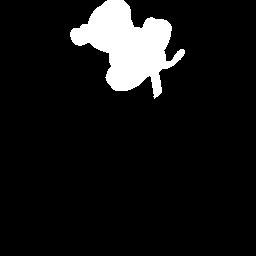

In [44]:
# Convert from 4-channels (RGBA) to 3-channels (RGB) when loading!
obj_amodal_mask = Image.open(sample_dict['camera_0000']['obj_0009']['segmentation'][0])
obj_amodal_mask

Below is the Amodal Content of `obj_0009`, as if it was unoccluded. The representation here is the same as scene-level rgb images.

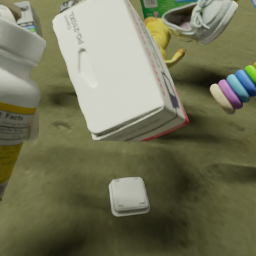

In [45]:
scene_img

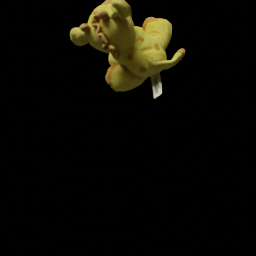

In [46]:
# Convert from 4-channels (RGBA) to 3-channels (RGB) when loading!
obj_amodal_content = Image.open(sample_dict['camera_0000']['obj_0009']['rgba'][0]).convert('RGB')
obj_amodal_content

Similiarly, we have Amodal Depth

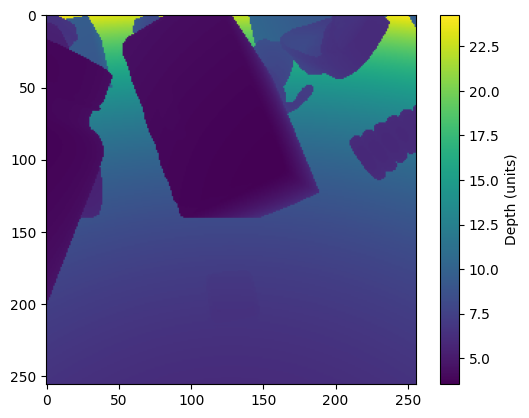

In [47]:
plt.imshow(depth_arr)
plt.colorbar(label='Depth (units)')

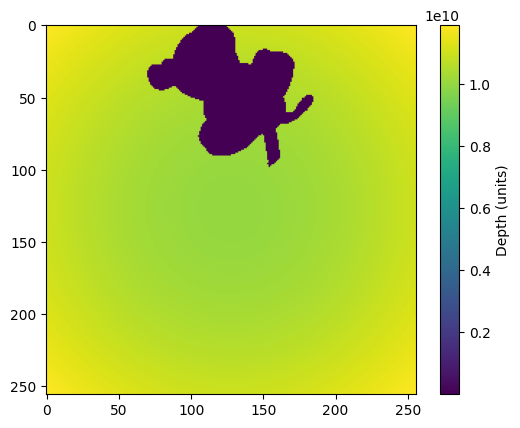

In [48]:
obj_amodal_depth = Image.open(sample_dict['camera_0000']['obj_0009']['depth'][0])
plt.imshow(np.array(obj_amodal_depth))
plt.colorbar(label='Depth (units)')

#### Visualization

In [49]:
imgs = []
for img_file in sample_dict['camera_0000']['scene']['rgba']:
    img = Image.open(img_file)
    imgs.append(img)
    # display(img)

In [50]:
imgs[0].save(
    "output.gif",
    save_all=True,
    append_images=imgs[1:],
    duration=500,
    loop=0
)

In [51]:
grid_tensors = make_obj_viz(sample_dict['camera_0000'])
make_vid(grid_tensors, 'temp_viz.mp4')

In [52]:
Video('temp_viz.mp4', embed=True)

STOP: Ask Questions Here!!!

# Example Baseline Experiment

Let's train a model from scratch to do something interesting!

> "Given an RGB image of a scene, let's predict all object masks, as a single class."

### Example Inputs & Outputs

In [53]:
sample_dir = 'ff5da6d6ecae486bb294aeaf5ee8f8a1/'

In [54]:
sample_dir = Path(sample_dir)
list(sample_dir.iterdir())

[PosixPath('ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0005'),
 PosixPath('ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0002'),
 PosixPath('ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0001'),
 PosixPath('ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0003'),
 PosixPath('ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0004'),
 PosixPath('ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0000')]

In [55]:
sample_dict = get_sample_dict(sample_dir)
sample_dict['camera_0000'].keys()

dict_keys(['scene', 'obj_0001', 'obj_0002', 'obj_0003', 'obj_0004', 'obj_0005', 'obj_0006', 'obj_0007', 'obj_0008', 'obj_0009', 'obj_0010', 'obj_0011', 'obj_0012', 'obj_0013', 'obj_0014', 'obj_0015', 'obj_0016', 'obj_0017', 'obj_0018', 'obj_0019'])

Example Model Input:
- Tensor of shape (C H W)
- RGB values are within the [0, 1] range

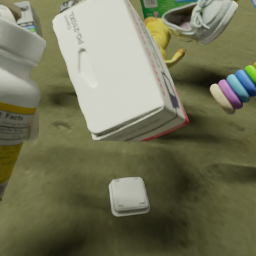

In [56]:
scene_img = Image.open(sample_dict['camera_0000']['scene']['rgba'][0]).convert('RGB')
scene_img

In [57]:
input_tensor = image_to_tensor(scene_img)
input_tensor.shape, input_tensor.min(), input_tensor.max()

(torch.Size([3, 256, 256]), tensor(0.0078), tensor(0.8902))

Example Model Output:
- Tensor of shape (C W)
- Binary values (0 for no object, 1 for object)

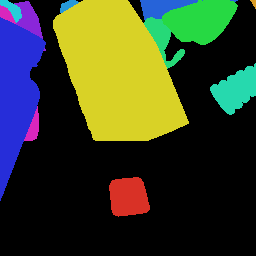

In [58]:
obj_masks = Image.open(sample_dict['camera_0000']['scene']['segmentation'][0])
obj_masks

In [59]:
np.array(obj_masks)

array([[11, 11, 11, ...,  3,  3,  3],
       [11, 11, 11, ...,  3,  3,  3],
       [11, 11, 11, ...,  3,  3,  3],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], shape=(256, 256), dtype=uint8)

In [60]:
output_tensor = torch.tensor(np.array(obj_masks))
output_tensor.shape, output_tensor.min(), output_tensor.max()

(torch.Size([256, 256]),
 tensor(0, dtype=torch.uint8),
 tensor(18, dtype=torch.uint8))

In [61]:
output_tensor = (output_tensor != 0).float()
output_tensor.shape, output_tensor.min(), output_tensor.max()

(torch.Size([256, 256]), tensor(0.), tensor(1.))

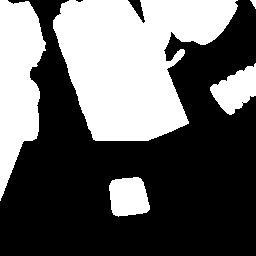

In [62]:
tensor_to_image(output_tensor)

### PyTorch Dataset

PyTorch!
- https://docs.pytorch.org/tutorials/beginner/basics/intro.html
- https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html

For simplicitly, we are working with just one sample folder!
- Feel free to extend this dataset to allow a "root directory" that contains multiple sample folders!

Some other important dataset design considerations:
- Train/test splits
- Deterministic behavior (for visualization purposes)

In [63]:
from torch.utils.data import Dataset

class SimpleDataset(Dataset):
    def __init__(self, sample_dir):
        sample_dir = Path(sample_dir)
        self.sample_dict = get_sample_dict(sample_dir)
        self.num_frames = 24
        self.num_cams = 6

    def __len__(self):
        # Total number of unique scene images
        return self.num_frames * self.num_cams

    def __getitem__(self, idx):
        rand_cam_idx = random.randint(0, self.num_cams-1)
        rand_frame_idx = random.randint(0, self.num_frames-1)

        scene_img = Image.open(sample_dict[f'camera_{rand_cam_idx:04d}']['scene']['rgba'][rand_frame_idx]).convert('RGB')
        obj_masks = Image.open(sample_dict[f'camera_{rand_cam_idx:04d}']['scene']['segmentation'][rand_frame_idx])

        scene = image_to_tensor(scene_img)
        mask = (torch.tensor(np.array(obj_masks)) != 0).float()

        return scene, mask

In [64]:
my_dataset = SimpleDataset('ff5da6d6ecae486bb294aeaf5ee8f8a1')
len(my_dataset)

144

In [65]:
scene, mask = my_dataset[0]
scene.shape, mask.shape

(torch.Size([3, 256, 256]), torch.Size([256, 256]))

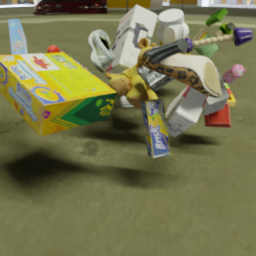

In [66]:
tensor_to_image(scene)

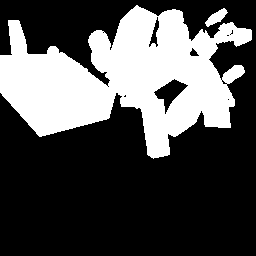

In [67]:
tensor_to_image(mask)

In [68]:
from torch.utils.data import DataLoader

my_dataloader = DataLoader(my_dataset, batch_size=4)

In [69]:
input_batch, target_batch = next(iter(my_dataloader))
input_batch.shape, target_batch.shape

(torch.Size([4, 3, 256, 256]), torch.Size([4, 256, 256]))

### Model

PyTorch's `nn` module is commonly used to build various neural networks (deep learning models)!

We'll start with a simple convolutional layer:
- 2 dimensions: *height + weight*
- 3 input channels: *rgb*
- Input batch shape: (bs, c, h, w)
- https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d

In [70]:
conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7, stride=1, padding=3)
conv1

Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))

In [71]:
input_batch.shape

torch.Size([4, 3, 256, 256])

In [72]:
conv1_output = conv1(input_batch)
conv1_output.shape, conv1_output.min(), conv1_output.max()

(torch.Size([4, 32, 256, 256]),
 tensor(-1.2363, grad_fn=<MinBackward1>),
 tensor(1.2123, grad_fn=<MaxBackward1>))

Neural networks are composed of:
- linear operations (matrix multiplications, `nn.Linear` & `nn.Conv` are actually just matmuls!)
- non-linearity operations (`nn.Relu` - *all negative numbers become 0*)
  - https://docs.pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU

In [73]:
relu1 = nn.ReLU()
relu1_output = relu1(conv1_output)
relu1_output.shape, relu1_output.min(), relu1_output.max()

(torch.Size([4, 32, 256, 256]),
 tensor(0., grad_fn=<MinBackward1>),
 tensor(1.2123, grad_fn=<MaxBackward1>))

We can compose these to make a "deeper" model!

Remember:
- our input is a 3-channel image
- our target should be a binary mask (e.g. 1 channel)

In [74]:
class SimpleConv2DModel(nn.Module):

    def __init__(self):
        super(SimpleConv2DModel, self).__init__()
        # Define multiple Conv2D layers with 'same' padding
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()

        self.final_conv = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.relu2(x)

        x = self.conv3(x)
        x = self.relu3(x)

        x = self.final_conv(x)

        return x

In [75]:
my_model = SimpleConv2DModel()
my_model

SimpleConv2DModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (final_conv): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [76]:
input_batch, target_batch = next(iter(my_dataloader))
input_batch.shape, target_batch.shape

(torch.Size([4, 3, 256, 256]), torch.Size([4, 256, 256]))

Let's visualize an input and output target!

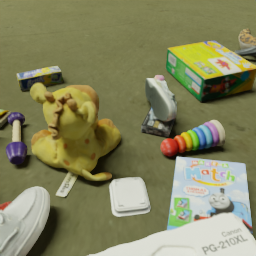

In [77]:
tensor_to_image(input_batch[0])

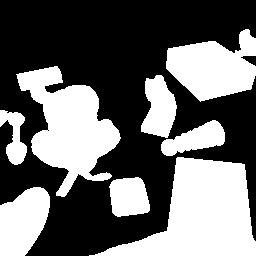

In [78]:
tensor_to_image(target_batch[0])

In [79]:
logits = my_model(input_batch)
logits.shape

torch.Size([4, 1, 256, 256])

Outputs should be close to 0 and 1, can use sigmoid!
- https://docs.pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html

We didn't use a 3rd ReLU since our last non-linearaity will be a simgoid, otherwise it wouldn't be possible to predict values close to 0!
- (All the negative numbers turn to 0, and 0 into a sigmoid is 0.5!)

In [80]:
logits.min(), logits.max()

(tensor(0.0093, grad_fn=<MinBackward1>),
 tensor(0.0707, grad_fn=<MaxBackward1>))

In [81]:
preds = torch.sigmoid(logits)
preds.min(), preds.max()

(tensor(0.5023, grad_fn=<MinBackward1>),
 tensor(0.5177, grad_fn=<MaxBackward1>))

In [82]:
rounded_preds = torch.round(preds)
rounded_preds.shape, rounded_preds.min(), rounded_preds.max()

(torch.Size([4, 1, 256, 256]),
 tensor(1., grad_fn=<MinBackward1>),
 tensor(1., grad_fn=<MaxBackward1>))

Let's visualize the model outputs!

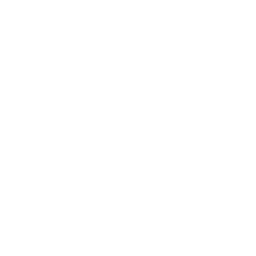

In [83]:
tensor_to_image(rounded_preds[0])

### Training

Now that we have a model that's able to provide outputs in the correct shape, we'll need a loss function:
- https://docs.pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html

Note that BCEWithLogitsLoss takes in the logits directly, sigmoid is applied within the loss function for you!

In [84]:
loss_fn = nn.BCEWithLogitsLoss()

In [85]:
logits.shape, target_batch.shape

(torch.Size([4, 1, 256, 256]), torch.Size([4, 256, 256]))

In [86]:
target_batch.unsqueeze(1).shape

torch.Size([4, 1, 256, 256])

In [87]:
loss = loss_fn(logits, target_batch.unsqueeze(1))
loss

tensor(0.6992, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

With a loss function, we're now able to apply an optimizer on loss values to *train* our neural network!

In [88]:
optimizer = torch.optim.Adam(my_model.parameters(), lr=3e-3)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.003
    maximize: False
    weight_decay: 0
)

Let's take a single "step" and see if the loss improves (on the same sample)!

In [89]:
loss

tensor(0.6992, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [90]:
optimizer.zero_grad()
loss.backward()
optimizer.step()

In [91]:
logits = my_model(input_batch)
loss = loss_fn(logits, target_batch.unsqueeze(1))
loss

tensor(0.6982, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

How about 10 more steps?

In [92]:
for i in range(10):
    logits = my_model(input_batch)
    loss = loss_fn(logits, target_batch.unsqueeze(1))
    print(loss)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

tensor(0.6982, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6939, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6880, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6805, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6725, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6613, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6502, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6335, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6130, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5889, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


This is a training loop! Some things to add:
- Use different batches
- Learning rate schedulers
- Batch size
- Metrics besides loss

It's important to split your data, and have a separate validation loop to ensure your model can transfer to new data unseen by the model during training
- Validation Dataloader (new videos, and even new objects)
- Metrics besides loss (don't compute loss / take optimization steps in the validation loop, otherwise your model will learn on your validation data!)

### Inference

Let's step 100 more times so the model learns a bit more (on this particular batch of data, possibly overfitting)

In [93]:
for i in range(100):
    logits = my_model(input_batch)
    loss = loss_fn(logits, target_batch.unsqueeze(1))
    print(loss)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

tensor(0.5646, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5505, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5345, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5215, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5171, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5042, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.4904, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.4766, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.4666, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.4602, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.4551, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.4486, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.4414, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.4322, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.4215, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.4156, grad_fn=<BinaryCrossEntro

Let's visualize the data & model outputs!

In [94]:
rounded_preds = logits.sigmoid().round()
rounded_preds.shape, rounded_preds.min(), rounded_preds.max()

(torch.Size([4, 1, 256, 256]),
 tensor(0., grad_fn=<MinBackward1>),
 tensor(1., grad_fn=<MaxBackward1>))

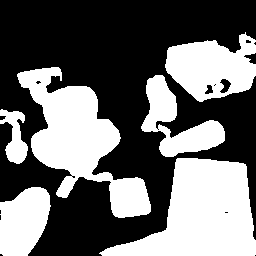

In [95]:
tensor_to_image(rounded_preds[0])

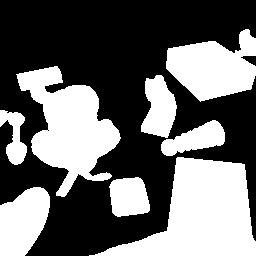

In [96]:
tensor_to_image(target_batch[0])

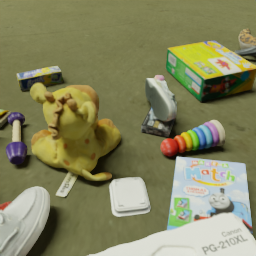

In [97]:
tensor_to_image(input_batch[0])

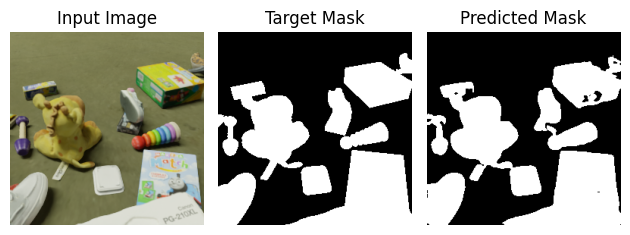

In [98]:
# Create a figure with 3 columns
fig, axes = plt.subplots(1, 3)

# Plot the images
axes[0].imshow(tensor_to_image(input_batch[0]), cmap='gray')  # First image
axes[0].set_title("Input Image")
axes[0].axis('off')  # Turn off axes

axes[1].imshow(tensor_to_image(target_batch[0]), cmap='gray')  # Second image
axes[1].set_title("Target Mask")
axes[1].axis('off')  # Turn off axes

axes[2].imshow(tensor_to_image(rounded_preds[0]), cmap='gray')  # Third image
axes[2].set_title("Predicted Mask")
axes[2].axis('off')  # Turn off axes

# Adjust layout
plt.tight_layout()
plt.show()

How would the model perform on a new batch of data?

In [99]:
input_batch, target_batch = next(iter(my_dataloader))

In [100]:
with torch.no_grad():
    logits = my_model(input_batch)
    
rounded_preds = logits.sigmoid().round()
rounded_preds.shape, rounded_preds.min(), rounded_preds.max()

(torch.Size([4, 1, 256, 256]), tensor(0.), tensor(1.))

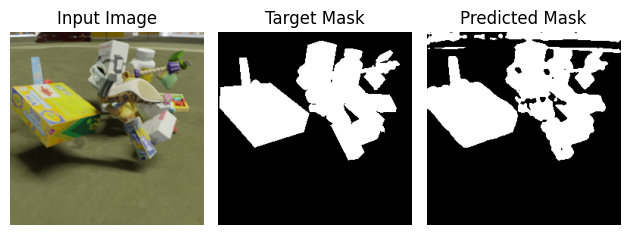

In [101]:
# Create a figure with 3 columns
fig, axes = plt.subplots(1, 3)

# Plot the images
axes[0].imshow(tensor_to_image(input_batch[0]), cmap='gray')  # First image
axes[0].set_title("Input Image")
axes[0].axis('off')  # Turn off axes

axes[1].imshow(tensor_to_image(target_batch[0]), cmap='gray')  # Second image
axes[1].set_title("Target Mask")
axes[1].axis('off')  # Turn off axes

axes[2].imshow(tensor_to_image(rounded_preds[0]), cmap='gray')  # Third image
axes[2].set_title("Predicted Mask")
axes[2].axis('off')  # Turn off axes

# Adjust layout
plt.tight_layout()
plt.show()

How can we say "how much" it got correctly?

In [102]:
rounded_preds.shape, target_batch.shape

(torch.Size([4, 1, 256, 256]), torch.Size([4, 256, 256]))

In [103]:
rounded_preds.shape, target_batch.unsqueeze(1).shape

(torch.Size([4, 1, 256, 256]), torch.Size([4, 1, 256, 256]))

This will set each "pixel" to be True if the output integer matches the target integer, e.g.
- 0 == 0
- 1 == 1

Be sure to check the shapes are the same before doing these comparison operations!

In [104]:
is_same = (rounded_preds == target_batch.unsqueeze(1))
is_same

tensor([[[[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [ True,  True,  True,  ...,  True,  True,  True],
          [ True,  True,  True,  ...,  True,  True,  True],
          [ True,  True,  True,  ...,  True,  True,  True]]],


        [[[ True,  True,  True,  ..., False, False,  True],
          [ True,  True,  True,  ..., False, False, False],
          [ True,  True,  True,  ..., False, False, False],
          ...,
          [ True,  True,  True,  ...,  True,  True,  True],
          [ True,  True,  True,  ...,  True,  True,  True],
          [ True,  True,  True,  ...,  True,  True,  True]]],


        [[[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [ True,  True,  True,  ...,  True,  T

White is "correct"
- We can quantify this by taking the total correct (i.e. 1) divided by the total amount of values!
- Total correct is just the sum of all the Trues
- Total amount is `numel` (<u>**num**</u>ber of <u>**el**</u>ements)

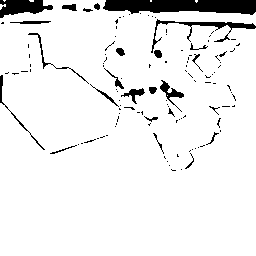

In [105]:
tensor_to_image(is_same[0].float())

In [106]:
print('Total Correct:', is_same.sum())
print('Total Amount:', is_same.numel())
print('Overall Accuracy:', is_same.sum() / is_same.numel())

Total Correct: tensor(235806)
Total Amount: 262144
Overall Accuracy: tensor(0.8995)


Note that this is the **Overall Accuracy**, i.e. the accuracy of both classes (class 0 "no object" + class 1 "is object")

To count how many "is_object" pixels it got correct, we can do a similar calculation, except we focus only on the "1" labels.

In [107]:
# True * True -> True
# True * False -> False
# False * True -> False
# False * False -> False

# -- This last case was previously "False == False -> True"!

# Boolean logic can allow us to "ignore" the 0 class

# You can technically write a loop to go over each pixel for each sample and check:
# -- "is predicted pixel == 1"
# -- "is target pixel == 1"
# "If so, total_count += 1"

# This will be incredibly slow to loop over each value, matrix operations are super fast, use them when possible!

is_same_1s = (rounded_preds==1) * (target_batch.unsqueeze(1)==1)
is_same_1s

tensor([[[[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]]],


        [[[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]]],


        [[[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, Fa

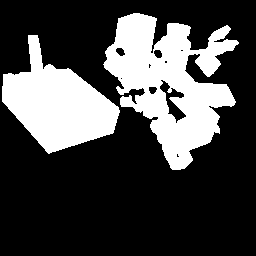

In [108]:
tensor_to_image(is_same_1s[0].float())

In [109]:
is_same_1s.sum(), (target_batch==1).sum(), is_same_1s.sum() / (target_batch==1).sum()

(tensor(78336), tensor(82547), tensor(0.9490))

In [110]:
print('Total Correct:', is_same_1s.sum())
print('Total Amount:', (target_batch==1).sum())
print('"is_object" Class Accuracy:', is_same_1s.sum() / (target_batch==1).sum())

Total Correct: tensor(78336)
Total Amount: tensor(82547)
"is_object" Class Accuracy: tensor(0.9490)


When focusing on just the "is_object" class, the accuracy is much lower than the Overall Accuracy! Why? Class imbalance!
- There are much more "background"/"no_object" pixels!

# 2025 DSC Tasks

Below are 4 tasks!

The goal here is to
- (1) First train models to solve the 4 tasks *quantiatively*
- (2) *Qualitatively* evaluate your trained models on real-world data, specifically on the <u>**Robotics Laboratory Pick and Place Dataset**</u>!

---

### Task 1.1: (Image-based) Modal Mask -> Amodal Mask

> "Given an image of the modal mask of an object, predict the amodal mask of the same object"

Inputs:
- RGB Frame
  - 3-channel image (3, 256, 256)
- Modal Mask of Object *i*
  - Binary (1-channel) image (1, 256, 256)

Outputs:
- Amodal Mask of Object *i*
  - Binary (1-channel) image (1, 256, 256)

---

### Task 1.2: (Image-based) Modal Content (RGB) -> Amodal Content (RGB)

> "Given an image of the modal RGB content of an object, predict the amodal RGB content of the same object"

> "Can use the amodal masks of that object"

Inputs:
- RGB Frame
  - 3-channel image (3, 256, 256)
- Amodal Mask of Object *i*
  - Binary (1-channel) image (1, 256, 256)
- RGB Content of Object *i*
  - 3-channel image (3, 256, 256)
  - Use the object's modal mask to "crop out" the RGB content of object *i*
  - Optional to use?
  
Outputs:
- Amodal RGB Content of Object *i*
  - 3-channel image (3, 256, 256)

---

### Task 2.1: (Video-based) Modal Mask -> Amodal Mask

> "Given a video of the modal mask of an object, predict the amodal mask of the same object"

Inputs:
- RGB Frames
  - N 3-channel images (N, 3, 256, 256)
- N Modal Masks of Object *i*
  - N Binary (1-channel) images (N, 1, 256, 256)

Outputs:
- N Amodal Masks of Object *i*
  - N Binary (1-channel) images (1, 256, 256)

---

### Task 2.2: (Video-based) Modal Content (RGB) -> Amodal Content (RGB)

> "Given a video of the modal RGB content of an object, predict the amodal RGB content of the same object"

> "Can use the amodal masks of that object"

Inputs:
- N RGB Frames
  - N 3-channel images (N, 3, 256, 256)
- N Amodal Masks of Object *i*
  - N Binary (1-channel) images (N, 1, 256, 256)
- N RGB Contents of Object *i*
  - N 3-channel images (N, 3, 256, 256)
  - Use the object's modal mask to "crop out" the RGB content of object *i*
  - Optional to use?
  
Outputs:
- N Amodal RGB Contents of Object *i*
  - N 3-channel images (N, 3, 256, 256)

---

### Bonus Task 3: Create Modal Masks with SAM2

> "Run SAM2 on the <u>**Robotics Laboratory Pick and Place Dataset**</u> and make your own modal masks!"
- https://github.com/facebookresearch/sam2

Inputs:
- Video
- For the object of interest: clickable points, bounding boxes, masks

Output:
- Masklet (Object masks across the video)

---

### Bonus Task 4: Re-ID of Objects

> "Given 2 objects, are they the same?"

> "Given an object, retrieve similar objects from a catalog of objects"

Inputs:
- Image or Video data?
- Modal or Amodal data?
- Masks, RGB Content?
  
Outputs:
- Are the 2 objects the same?
- Retrieved similar objects A, B, C, given object X?

---

# End

Have fun!

# More advanced examples/extra material

### Utils

In [ ]:

def calculate_metrics(amodal_mask_preds, 
                      amodal_mask_labels, 
                      amodal_content_preds,
                      amodal_content_labels):
    """
    Here, you can calculate non-loss metrics like mIOU, accuracy, J&F scores.

    And non-loss image generation metrics between the predicted and ground-truth amodal content
    Such as Inception Score, Frechet Inception Distance, Learned Perceptual Patch Similarity (LPIPS),
    Structure Similarity Index Metric (SSIM), Peak Signal-Noise Ratio (PSNR)

    These should all have easy-to-use implementations in libraries such as TorchMetrics.
    """
    return None


### Dataset

#### Class

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import os
import torch
from PIL import Image
import numpy as np
import random

class MOVi_Dataset(Dataset):
    def __init__(self, split = 'train' or 'test', 
                 n_frames = 8,
                 n_samples = 1000,
                 #box_format = 'xywh'
                 ):
        print('Dataset init on', split)

        self.split = split
        self.top_dir = f'/data1/Video/CVP/data/MOVi-MC-AC/{split}/'
        print('Init data top dir:', self.top_dir)

        #self.box_format = box_format

        # Get directories in data_dir/train-test
        self.scenes = [entry for entry in os.listdir(self.top_dir) if os.path.isdir(os.path.join(self.top_dir, entry))]

        self.n_frames = n_frames
        self.n_samples = n_samples

    def __len__(self):
        # In theory this could be like n_scenes*n_objects
        # To get total number of (cam-invariant) objects
        return self.n_samples

    def load_cam_frames(self, scene, 
                    cam_idx,
                    start, stop, 
                    modality):
        """
        One load-frames loads camera-level stuff (rgb, depth)
        The other one loads object-level stuff (scene/cam/obj_i/amodal_mask or content)
        """
        # Load frame range
        imgs = []
        suffix = '.png'

        totensor = ToTensor()

        for i in range(start, stop):
            # loads train/scene_id/cam_id/frames_or_depth_or_modal/frame_id.png
            if modality == 'modal_masks':
                load_file = f'{self.top_dir}/{scene}/{cam_idx}/segmentation_{str(i).zfill(5)}{suffix}'
            
            if modality == 'rgba_full':
                load_file = f'{self.top_dir}/{scene}/{cam_idx}/rgba_{str(i).zfill(5)}{suffix}'

            if modality == 'depth_full':
                load_file = f'{self.top_dir}/{scene}/{cam_idx}/depth_{str(i).zfill(5)}.tiff'

            tens = totensor(Image.open(load_file))
            imgs.append(tens)

        tensor = torch.stack(imgs, dim = 1)

        return tensor
    
    def load_obj_frames(self, scene, 
                    cam_idx,
                    object_idx,
                    start, stop, 
                    modality):
        """
        This loaded loads object-level stuff
        """
        # Load frame range
        imgs = []
        # amodal_segs, content, rgba_full, modal_masks, depth_full
        suffix = '.png'

        totensor = ToTensor()

        for i in range(start, stop):
            if modality == 'amodal_segs':
                load_file = f'{self.top_dir}/{scene}/{cam_idx}/{object_idx}/segmentation_{str(i).zfill(5)}{suffix}'
                tens = totensor(Image.open(load_file))

            if modality == 'content':
                load_file = f'{self.top_dir}/{scene}/{cam_idx}/{object_idx}/rgba_{str(i).zfill(5)}{suffix}'
                tens = totensor(Image.open(load_file).convert('RGB'))
                
            if modality == 'depth_full':
                load_file = f'{self.top_dir}/{scene}/{cam_idx}/{object_idx}/rgba_{str(i).zfill(5)}{suffix}'
                tens = totensor(Image.open(load_file).convert('RGB'))
            imgs.append(tens)

        tensor = torch.stack(imgs, dim = 1)
        return tensor


    def __getitem__(self, idx):
        # Select a random sample
        random_scene = np.random.choice(self.scenes)

        # Get the list of objects in that sample
        all_object_ids = self.all_objects(self.top_dir + random_scene + '/camera_0000/' )
        
        # Pick a random object 
        target_object_id = np.random.choice(all_object_ids)

        """
        Loading from multiple cameras in parallel:
        """

        # Make these random
        start = random.randint(0, 24-self.n_frames)
        stop = start+self.n_frames

        i = random.randint(0, 5)
        frames, depths, modal_masks, amodal_segs, amodal_content = self.load_camera(random_scene, cam_id = f'camera_{str(i).zfill(4)}', obj_id = target_object_id, start = start, stop = stop)

        modal_masks = modal_masks*255
        modal_masks = modal_masks.to(torch.uint8)
        sample = {
            'frames': frames,
            'depths': depths,
            'modal_masks': modal_masks,
            'amodal_masks': amodal_segs,
            'amodal_content': amodal_content,
        }
        return sample

    
    def load_camera(self, scene_id, cam_id, obj_id, start, stop):

        # Load the target objects 
        modal_segs = self.load_cam_frames(scene_id, 
                                            cam_id,
                                            start, stop,
                                            'modal_masks')

        modal_segs = modal_segs*255
        modal_segs = modal_segs.int()

        # Load frames corresponding to inputs
        frames = self.load_cam_frames(scene_id, 
                                      cam_id, 
                                      start, 
                                      stop, 
                                      'rgba_full')[:-1]

        # Load depth (though we will have to replace with Depth-Anything-V2 estimates)
        depths = self.load_cam_frames(scene_id, cam_id, start, stop, 'depth_full')

        amodal_segs = self.load_obj_frames(scene_id, cam_id, obj_id, start, stop, 'amodal_segs')
        amodal_content = self.load_obj_frames(scene_id, cam_id, obj_id, start, stop, 'content')
        
        return frames, depths, modal_segs, amodal_segs, amodal_content
    
    def all_objects(self, pth):
        """
        Given a path, get the objects at that path using regex
        """
        #print('looking for all objects at', pth)
        
        # Find all matches
        matches = []
        for fname in sorted(os.listdir(pth)):
            if 'obj_' in fname:
                matches.append(fname)

        #print(matches)
        return matches # list of ['obj_0001', 'obj_0009',...]

#### Example Usage & Visualzations

In [ ]:
dataset = MOVi_Dataset(split = 'train', n_frames = 1)
sample = next(iter(dataset))

print(sample.keys())

for key, value in sample.items():
    print(key, value.shape)

In [ ]:

import matplotlib.pyplot as plt

x = sample['depths'][0][0]
print(x.min(), x.max())
plt.imshow(x)
plt.show()

plt.imshow(sample['frames'][:, 0].permute(1,2,0))
plt.show()


plt.imshow(sample['amodal_masks'][:, 0].permute(1,2,0))
plt.show()

plt.imshow(sample['amodal_content'][:, 0].permute(1,2,0))
plt.show()

### Model

#### Class

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class conv2d_inplace_spatial(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, pooling_function, activation = nn.GELU()):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(out_channels),
            activation,
            pooling_function,
        )

    def forward(self, x):
        return self.double_conv(x)
    
class Upscale(nn.Module):
    def __init__(self, scale_factor=(2, 2), mode='bilinear', align_corners=False):
        super(Upscale, self).__init__()
        self.scale_factor = scale_factor
        self.mode = mode
        self.align_corners = align_corners

    def forward(self, x):
        return F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode, align_corners=self.align_corners)

class Unet_Image(nn.Module):
    def __init__(self, in_channels = 4, mask_content_preds = False):
        super().__init__()

        self.mpool_2 = nn.MaxPool2d((2, 2))

        self.down1 = conv2d_inplace_spatial(in_channels, 32, self.mpool_2)
        self.down2 = conv2d_inplace_spatial(32, 64, self.mpool_2)
        self.down3 = conv2d_inplace_spatial(64, 128, self.mpool_2)
        self.down4 = conv2d_inplace_spatial(128, 256, self.mpool_2)

        self.upscale_2 = Upscale(scale_factor=(2, 2), mode='bilinear', align_corners=False)

        self.up1 = conv2d_inplace_spatial(256, 128, self.upscale_2)
        self.up2 = conv2d_inplace_spatial(256, 64, self.upscale_2)
        self.up3 = conv2d_inplace_spatial(128, 32, self.upscale_2)
        
        self.up4_amodal_mask = conv2d_inplace_spatial(64, 1, self.upscale_2, activation = nn.Identity())
        self.up4_amodal_content = conv2d_inplace_spatial(64, 3, self.upscale_2, activation = nn.Identity())

        # Optional arguments
        self.mask_content_preds = mask_content_preds # Should we mask the amodal content prediction by the amodal mask prediction?

        # Optimization
        self.mse_loss = nn.L1Loss()
        self.bce_loss = nn.BCEWithLogitsLoss()


        # Self-attention feature enrichment
        #max_seq = 16*16*6
        #token_dim = 256
        #self.pos_enc = nn.Parameter(torch.zeros((max_seq, 1, token_dim))) # seq b dim
        #encoder_layer = nn.TransformerEncoderLayer(d_model=token_dim, nhead=8)
        #self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=4)
        
    def encode(self, x):
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)

        # [torch.Size([6, 32, 4, 128, 128]), torch.Size([6, 64, 2, 64, 64]), torch.Size([6, 128, 1, 32, 32]), torch.Size([6, 256, 1, 16, 16])]
        return x1, x2, x3, x4
    
    def decode(self, h1, h2, h3, h4):
        h4 = self.up1(h4) # 6, 256, 1, 16, 16 -> 6, 128, 1, 32, 32 (double spatial, then conv-in-place channels to half)
        h34 = torch.cat((h3, h4), dim = 1) # (6, 2*128, 1, 32, 32)

        h34 = self.up2(h34) # 6, 256, 1, 32, 32 -> 6, 128, 2, 64, 64
        h234 = torch.cat((h2, h34), dim = 1)

        h234 = self.up3(h234)
        h1234 = torch.cat((h1, h234), dim = 1)
        
        logits_amodal_mask = self.up4_amodal_mask(h1234)
        logits_amodal_content = self.up4_amodal_content(h1234)
        return logits_amodal_mask, logits_amodal_content
    
    def encode_decode(self, x):
        """
        input image tensor: (bs, c, h, w)
        """
        b, c, h, w = x.shape

        # Multiscale features x1, x2, x3, x4
        x1, x2, x3, x4 = self.encode(x)

        # You could add code here for example more layers that modify the latent x4? Be creative :)

        # Decode using enriched features
        logits_amodal_mask, logits_amodal_content = self.decode(x1, x2, x3, x4)

        return logits_amodal_mask, logits_amodal_content
        
    def forward(self, batch):
        # concat rgb and modal masks as input to model
        model_input = torch.cat((batch['frames'], batch['modal_masks']), dim = 1)

        # Remove time dimension from a few things (add it back in later when you make your video model!)
        model_input = model_input.squeeze(2) # remove time dimension (you will probably want it later!)
        amodal_mask_labels = batch['amodal_masks'].float().squeeze(2)
        amodal_content_labels = batch['amodal_content'].float().squeeze(2)

        # Model input
        #print('model input:', model_input.shape)
        
        logits_amodal_mask, logits_amodal_content = self.encode_decode(model_input)

        # Should we mask the amodal content prediction by the predicted amodal mask?
        if self.mask_content_preds:
            # Element-wise masking by self-predictions:
            logits_amodal_content = logits_amodal_mask.sigmoid().round() * logits_amodal_content

        # print('0000 Verify Shapes 0000')
        # print(logits_amodal_mask.shape)
        # print(logits_amodal_content.shape)
        # print(amodal_mask_labels.shape)
        # print(amodal_content_labels.shape)
        # Loss between predicted amodal masks/content and GT masks/content
        mask_loss, content_loss = self.loss_function(logits_amodal_mask, 
                                                        amodal_mask_labels,
                                                        logits_amodal_content, 
                                                        amodal_content_labels)
        
        loss = mask_loss + content_loss

        # Calculate metrics into a dictionary
        metrics = calculate_metrics(logits_amodal_mask, 
                                    amodal_mask_labels, 
                                    logits_amodal_content,
                                    amodal_content_labels)
        
        # Report the metrics we calculated in addition to our loss functions
        metrics = {
            'loss': loss.data.item(),
            'mask_loss': mask_loss.data.item(),
            'content_loss': content_loss.data.item(),
            'other_metrics_to_monitor': 0 # add more metrics here - just make sure they are a number
        }
        return loss, metrics
    def loss_function(self,
                    amodal_mask_preds,
                    amodal_mask_labels,
                    amodal_content_preds,
                    amodal_content_labels):
        mask_loss = self.bce_loss(amodal_mask_preds, amodal_mask_labels)
        content_loss = self.mse_loss(amodal_content_preds, amodal_content_labels)
        return mask_loss, content_loss

#### Example Usage

In [ ]:
# Make a U-net which expects a batch of 4-channel images as input (batch_size, channels=4, height, width)
model = Unet_Image(4)

# Make a dummy tensor to test the model can successfully apply its layers and get an output
batch_size = 1
rand_input = torch.randn((batch_size, 4, 256, 256))

# Apply the model to the input - we use encode decode here rather than forward
# because we don't have the full batch yet - we will later
logits_amodal_mask, logits_amodal_content = model.encode_decode(rand_input)
print('Model output:', logits_amodal_mask.shape, logits_amodal_content.shape)

# For our use-case, we are predicting amodal masks and amodal content
# The amodal mask prediction should be (batch_size, 1, h, w) for a binary mask and the 
# Amodal content prediction should be  (batch_size, 3, h, w) for an rgb object prediction

### Training

#### Utils

In [ ]:
"""
Now we have a model, a forward call, and a calculated loss to backpropegate and propegate
"""

def batch_to_device(batch, device):
    for key, value in batch.items():
        batch[key] = value.to(device)

    return batch

def aggregate_metrics(list_of_dicts):
    """
    Given a list of dictionaries containing metrics, aggregate into one dictionary
    """
    mean_dict = {
        key: sum(d[key] for d in list_of_dicts) / len(list_of_dicts)
        for key in list_of_dicts[0].keys()
    }
    return mean_dict

def val_step(batch, model):
    """
    Take a validation step to get predictions and metrics on a batch
    """
    model.eval()
    loss, metrics = model.forward(batch)
    model.train()
    return loss, metrics

def train_step(batch, model, optimizer):
    model.train()
    optimizer.zero_grad()
    loss, metrics = model.forward(batch)
    loss.backward()
    optimizer.step()

    return loss, metrics

def train_epoch(model, optimizer, dataloader, device):
    """
    Iterate over the 
    """
    epoch_metrics = []
    for batch in dataloader:
        batch = batch_to_device(batch, device)
        _, metrics = train_step(batch, model, optimizer)
        epoch_metrics.append(metrics)

    # Aggregate list of metrics 
    aggregated_metrics = aggregate_metrics(epoch_metrics)
    return aggregated_metrics

def valid_epoch(model, dataloader, device):
    epoch_metrics = []
    for batch in dataloader:
        with torch.no_grad():
            batch = batch_to_device(batch, device)
            _, metrics = val_step(batch, model)
            epoch_metrics.append(metrics)

    # Aggregate list of metrics 
    aggregated_metrics = aggregate_metrics(epoch_metrics)
    return aggregated_metrics

def train(model, optimizer, train_dataloader, val_dataloader, n_epochs, device):
    list_of_train_metrics = []
    list_of_valid_metrics = []
    for epoch in range(n_epochs):
        print('Starting Epoch', epoch)
        train_epoch_metrics = train_epoch(model, optimizer, train_dataloader, device)
        list_of_train_metrics.append(train_epoch_metrics)

        valid_epoch_metrics = valid_epoch(model, val_dataloader, device)
        list_of_valid_metrics.append(valid_epoch_metrics)

        if epoch%1 == 0:
            print(f'Epoch {epoch} metrics:')
            format_metrics(train_epoch_metrics, valid_epoch_metrics, epoch)

    return list_of_train_metrics, list_of_valid_metrics

from tabulate import tabulate

def format_metrics(training_metrics, validation_metrics, epoch):
    # Combine the metrics into rows for the table
    rows = []
    for metric in training_metrics.keys():
        train_value = training_metrics.get(metric, "N/A")
        val_value = validation_metrics.get(metric, "N/A")
        rows.append([metric, train_value, val_value])
    
    # Create the table with headers
    table = tabulate(rows, headers=[f"Metric - Epoch {epoch}", "Training", "Validation"], tablefmt="grid")
    print(table)



#### Train

In [ ]:
# Arguments
learning_rate = 3e-5 # 3e-4?...
batch_size = 32
mask_content_preds = True
n_workers = 32
n_epochs = 20

# Dataloaders
train_dataset = MOVi_Dataset(split = 'train', 
                             n_frames = 1,
                             n_samples = 64)
train_dataloader = DataLoader(train_dataset, 
                              num_workers = n_workers, 
                              batch_size=batch_size)

val_dataset = MOVi_Dataset(split = 'test', 
                           n_frames = 1,
                           n_samples = 32)
val_dataloader = DataLoader(train_dataset, 
                            num_workers = n_workers, 
                            batch_size=batch_size)


"""
Our model is a torch model which contains the layers we will train.
This model takes the RGB image and the modal mask of an object (an attention cue) 
And will be trained to return the amodal (unobscured) mask as well as the amodal content.
Think of this as training for "x-ray vision" - given an attention cue, return what the unoccluded object
would look like, given hints from the image or video.

Extending this to video will be the next step, so start thinking about how you can combine
multiple frames of information to predict what an occluded object looks like.
"""

device = 0
model = Unet_Image(in_channels = 4).to(device) # ModalMask+RGB -> AmodalMask+AmodalContent

optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

train(model, optim, train_dataloader, val_dataloader, n_epochs = n_epochs, device = device)

"""
While this trains, you should see the epoch performances greatly improving on the training split.
They may or may not improve on the validation split depending on many factors.
Now that this code runs though, try turning up the size of the datasets and see what affect that has.

Then eventually you can start designing a model intended to track and segment objects from video
which will require setting the datasets n_frames to a larger number, and re-designing your torch model.

Hopefully everything else remains working though! I would copy this notebook to have around for referce
Then make your own notebook where you experiment with new designs! :)
"""